<a href="https://colab.research.google.com/github/arminwitte/FoolsUNet/blob/main/foolsunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!git clone https://github.com/arminwitte/FoolsUNet.git

Cloning into 'FoolsUNet'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 23 (delta 10), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 168.82 KiB | 3.13 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [23]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [24]:
from tensorflow.keras import layers

In [25]:
class SqueezeExcite(layers.Layer):
    """
    https://keras.io/examples/vision/patch_convnet/

    Applies squeeze and excitation to input feature maps as seen in
    https://arxiv.org/abs/1709.01507.

    Args:
        ratio: The ratio with which the feature map needs to be reduced in
        the reduction phase.

    Inputs:
        Convolutional features.

    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio,
            activation="relu",
            use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x

In [26]:

class InverseResidualBlock(layers.Layer):
    """Implements an Inverse Residual Block like in MobileNetV2 and MobileNetV3

    https://stackoverflow.com/a/61334159

    Args:
        features: Number of features.
        expand_factor: factor by witch to expand number of layers
        strides: Stride used in last convolution.
        batch_norm: flag if Batch Normalisation should be used.

    Inputs:
        Convolutional features.

    Outputs:
        Modified feature maps.
    """

    def __init__(self, features=16, expand_factor=4, strides=1, batch_norm=True, **kwargs):
        super().__init__(**kwargs)
        self.features = features
        self.expand_factor = expand_factor
        self.strides = strides
        self.batch_norm = batch_norm

    def get_config(self):
        config = super().get_config()
        config.update({"features": self.features,
                       "expand_factor": self.expand_factor,
                       "strides": self.strides,
                       "batch_norm": self.batch_norm, })
        return config

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(filters*expand_factor, (1,1), strides=1)
        if self.batch_norm:
            self.bn1 = layers.BatchNormalization()
        self.activation1 = layers.Activation('relu6')
        self.dwise = layers.DepthwiseConv2D(3, padding='same', strides=strides)
        if self.batch_norm:
            self.bn2 = layers.BatchNormalization()
        self.activation2 = layers.Activation('relu6')
        self.squeeze_exite = SqueezeExcite(ratio=4)
        self.conf2 = layers.Conv2D(squeeze, (1,1), strides=1, padding='same')
        if self.batch_norm:
            self.bn3 = layers.BatchNormalization()

    def call(self, x):
        shortcut = x
        x = self.conf1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.activation1(x)
        x = self.dwise(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.activation2(x)
        x = self.squeeze_excite(x)
        x = self.conv2(x)
        if self.batch_norm:            x = self.bn3(x)

        if (
            # stride check enforces that we don't add residuals when spatial
            # dimensions are None
            strides == 1 and
            # Depth matches
            x.get_shape().as_list()[3] == shortcut.get_shape().as_list()[3]
        ):
            x = tf.keras.layers.Add()([x, shortcut])

        return x

In [27]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

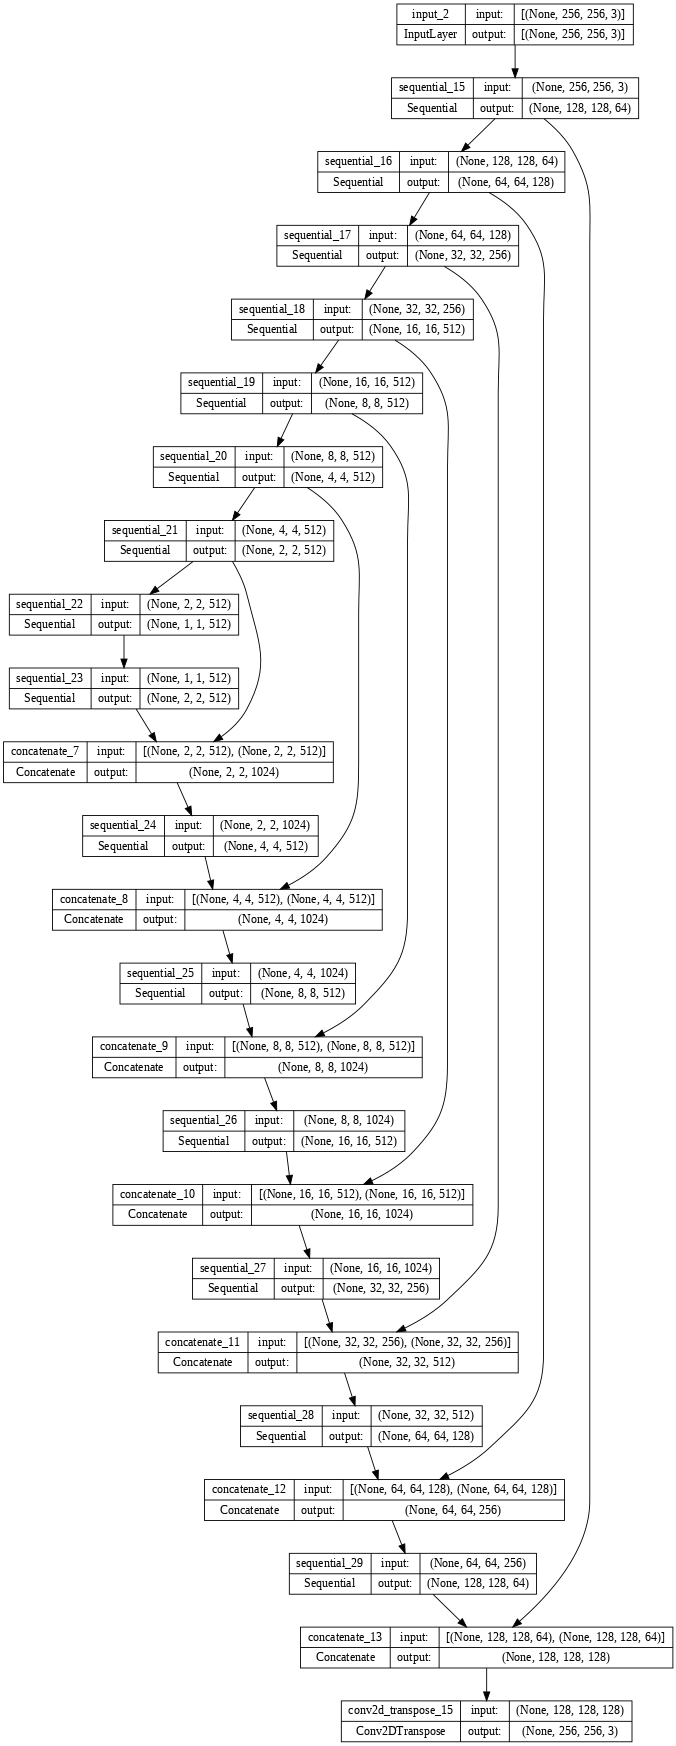

In [28]:

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [29]:
import tensorflow_datasets as tfds

In [30]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [31]:

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [43]:

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (256, 256))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (256, 256),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [44]:

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [45]:

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [46]:

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [47]:

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [48]:
model = Generator()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          #callbacks=[DisplayCallback()]
)

Epoch 1/20
 1/57 [..............................] - ETA: 1:26:55 - loss: 1.0722 - accuracy: 0.4341